##Librerias

In [1]:
!pip3 install emoji

     |████████████████████████████████| 168 kB 4.2 MB/s 
  Created wheel for emoji: filename=emoji-1.6.0-py3-none-any.whl size=168256 sha256=1da2bc54094d48b911d628e9612042237863bfac0497cfbb0ae421e595c1f000
  Stored in directory: /root/.cache/pip/wheels/f7/d7/74/c720aaf345a042b0c2d74361873258c5e8649b7f11b2ccce49
Successfully built emoji


In [2]:
!pip install langid

     |████████████████████████████████| 1.9 MB 2.6 MB/s 
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941187 sha256=efbca09285d09245cb299acba8393230edce9cad95e4a6c7688b0eda8e900b5b
  Stored in directory: /root/.cache/pip/wheels/2b/bb/7f/11e4db39477278161e882eadc46fb558949a28b13470fc74b8
Successfully built langid


In [3]:
!pip install langdetect

     |████████████████████████████████| 981 kB 2.8 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=ae65d4b67c4eb003d56f09147acb77d843152b222c3e71353c76a4f0ee04c52b
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [4]:
import emoji

In [5]:
import pandas as pd
import numpy as np
import re   

## Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

##KFolds
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

#NLP
import nltk
from nltk.tokenize import word_tokenize
import spacy
nltk.download('punkt')

from nltk.corpus import stopwords
nltk.download('stopwords')
#spanish_stopwords = stopwords.words('spanish')
from string import punctuation

from sklearn.feature_extraction.text import CountVectorizer       
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

## Models
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
# Multilayer perceptron
from sklearn.neural_network import MLPClassifier

#Metricas
## Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
#from sklearn.metrics import f1_score

#Ensembles
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB

##Otros
from sklearn.pipeline import Pipeline
import langid
from langdetect import detect
import textblob

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##Lectura de Df

In [6]:
spacy.cli.download('es_core_news_md')

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_md')


In [7]:
nlp = spacy.load('es_core_news_md')

In [8]:
dataIG_01 = pd.read_excel("ComentariosInstagram.xlsx")
dataEmojiA = pd.read_excel("DiccionarioEmojisEspacios.xlsx")

In [9]:
dataIG_01.head(3)

,Texto,Etiquetado
0,@giomaeli muchas gracias 🙏🏻😊,Positivo
1,@alexisjosueh ¡Felicitaciones por este gran tr...,Positivo
2,"@alexisjosueh felicidades, excelente trabajo🙌🏻",Positivo


##Agrupamiento de datos

In [10]:
print(dataIG_01.shape)
dataIG_01.groupby("Etiquetado").count().reset_index()

(3259, 2)


,Etiquetado,Texto
0,Negativo,1033
1,Neutro,770
2,Positivo,1455


In [11]:
dataIG_01.groupby("Etiquetado").count()/sum(dataIG_01.groupby("Etiquetado").count().reset_index().Texto)

,Texto
Etiquetado,
Negativo,0.317066
Neutro,0.236341
Positivo,0.446593


##Limpieza de datos

In [12]:
#Lista de palabras en español
spanish_stopwords = stopwords.words('spanish')
#Lista de signos de puntuación
non_words = list(punctuation)
#Agregando signos de puntuación en español
non_words.extend(['¿', '¡'])
non_words.extend(map(str,range(10)))
print(non_words)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '¿', '¡', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [13]:
## Asignamos el metodo SnowballStemmer (ignore_stopwords: sin afectar a los stopwords)
stemmer = SnowballStemmer('spanish',ignore_stopwords=True) 

##stem_tokens: Funcion que permite asignar a cada palabra su raiz.
##Necesita recibir un texto "tokenizado" y el stemmer para identificar la raiz de las palabras del idioma elegido.
def stem_tokens(tokens, stemmer):
    stemmed = []                                 ## Vector Inicial.
    for item in tokens:                          ## Iterativo que recorre todos las palabras dentro del tokens ingresado.
        stemmed.append(stemmer.stem(item))       ## Asigna la raiz de cada palabra ingresado y lo almacena en el vector incial.
    return stemmed                               ## La funcion devuelve el vector inicial.

##tokenize: Funcion que permite separar/partir/tokenizar un texto (+ stemmer). Además, se le agrego limpiar los non_words.
##Esta funcion despues de tokenizar, aplica el stemmer a cada token creado.
##Necesita recibir un texto para poder "tokenizarlo".
def tokenize(text):
    # remove non letters
    text = ''.join([c for c in text if c not in non_words])  ## Remplaza por un valor vacio a los non_words.
    # tokenize
    tokens =  word_tokenize(text)                            ## Tokeniza el texto por palabras.

    # stem
    try:
        stems = stem_tokens(tokens, stemmer)                 ## Se invoca la funcion stem_tokens.
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems

In [14]:
dataIG_02 = dataIG_01.copy()
dataIG_02["Texto2"] = None
dataIG_02["LenComment"] = None
dataIG_02.head(3)

,Texto,Etiquetado,Texto2,LenComment
0,@giomaeli muchas gracias 🙏🏻😊,Positivo,None,None
1,@alexisjosueh ¡Felicitaciones por este gran tr...,Positivo,None,None
2,"@alexisjosueh felicidades, excelente trabajo🙌🏻",Positivo,None,None


In [19]:
list_emojis = list(dataEmojiA.Emoji)
print(list_emojis)

['👏', '❤️', '🙌', '😍', '😭', '🏻', '😢', '😂', '🔥', '👍', '💪', '🏼', '🤡', '🇪', '💕', '🇵', '🥺', '♥', '😊', '🥑', '🤣', '🏽', '🙏', '🤗', '💜', '🎉', '😱', '👌', '😎', '💛', '😘', '✨', '😮', '😔', '🖤', '🤔', '💙', '🤩', '👎', '💯', '🙄', '👀', '🔝', '😅', '😉', '💔', '💚', '💖', '🎓', '♀', '💗', '😻', '🤭', '🏾', '😆', '☹', '🤧', '🥰', '😁', '😃', '💓', '✌', '♂', '😀', '😞', '🤮', '🙋', '🙈', '😪', '🐀', '😌', '🐔', '😑', '🏿', '🐷', '🌟', '😳', '💞', '😣', '🦠', '😥', '🌈', '🤙', '🐺', '🥳', '☺', '🙁', '🌸', '🤦', '🎊', '🍀', '🙊', '😒', '😐', '🎶', '🧐', '😄', '😏', '☝', '📲', '👐', '😠', '🤬', '🙃', '🙂', '🏆', '😬', '🤷', '💝', '👨', '\U0001f972', '🤓', '😫', '👩', '😿', '👉', '💢', '🤘', '📌', '😇', '😡', '😩', '♡', '❣', '🤨', '💘', '🌴', '😲', '😓', '👇', '🍻', '😨', '💃', '💇', '🤤', '📷', '📸', '🐿', '😋', 'Ⓜ', '🎸', '✊', '🎈', '🚨', '🤞', '⚠', '💻', '💟', '🔴', '😕', '😜', '😯', '\U0001f90d', '🤢', '💫', '🧡', '🍾', '💎', '👆', '🎮', '🍃', '🌼', '🌹', '🌳', '🌝', '🐦', '🇻', '⬅', '🐥', '✔', '⚡', '⚫', '🐢', '🐐', '🐉', '😚', '😛', '☄', '😟', '🦈', '🍺', '🦄', '♻', '🌻', '🌺', '🌷', '🤪', '⚪', '🌞', '🥚', '🌐', '🚛', '🚻', '🥂', '🤝', '🤟', 

In [20]:
def eliminar_usuarios_etiquetados(texto):
  list_words = texto.split()
  list_final = []
  for i in range(len(list_words)):
    word = list_words[i]
    if (word[0]!="@"):
      list_final.append(word)
  return ' '.join(list_final)

In [21]:
def reemplazar_repetidas(texto):
  #Caracteres a validar
  import string

  alphabet_string = string.ascii_lowercase
  alphabet_list = list(alphabet_string)
  l_dos_excep = ['a','e','o','l','n']
  l_una_excep = set(alphabet_list) - set(l_dos_excep)

  #Variables
  list_palabras = texto.lower().split()
  list_final = []
    
  for i in range(len(list_palabras)):
    palabra = list_palabras[i]
    #Maximo una ocurrencia
    for w in l_una_excep:
      pattern = w + '{2,}'
      palabra = re.sub(pattern, w, palabra)
    #Maximo dos ocurrencias
    for w in l_dos_excep:
      pattern = w + '{3,}'
      palabra = re.sub(pattern, w, palabra)
    list_final.append(palabra)

  return ' '.join(list_final)

In [22]:
##Depurando comentario por comentario
for i in range(dataIG_02.shape[0]):
  aux_text= dataIG_02.Texto.iloc[i]
  if (pd.isna(aux_text)):
    dataIG_02["Texto2"].iloc[i] = None
    dataIG_02["LenComment"].iloc[i] = None
  else:
    aux_text = eliminar_usuarios_etiquetados(aux_text)
    aux_text = reemplazar_repetidas(aux_text)
    aux_text = ''.join([c for c in aux_text if c not in list_emojis])
    aux_text = ''.join([c for c in aux_text if c not in emoji.UNICODE_EMOJI['en']]) ## Codigo para completar emojis que no se reconocian en la lista de emojis. ej el corazon
    len_comment = len(aux_text.strip()) ## largo del comentario, sin emojis
    aux_text = ''.join([c for c in aux_text if c not in non_words]) ##Eliminando no palabras
    tokens =  word_tokenize(aux_text) ## Tokenizando comentario depurado
    aux_text = ' '.join([c for c in tokens if c not in spanish_stopwords]) ## Eliminando los stop words español    
    tokens =  word_tokenize(aux_text) ## Tokenizando comentario depurado
    aux_text = ' '.join(stem_tokens(tokens, stemmer)) ## identificación de raiz de cada palabra
    #aux_text = ''.join([c for c in aux_text if c in list_emojis_pos]) ##Se tendria que crear una lista de emojis positivos (manualmente), apartir de la lista de emojis
    #aux_text = ''.join([c for c in aux_text if c in list_emojis_neg]) ##Se tendria que crear una lista de emojis negativos (manualmente), apartir de la lista de emojis
    #Quisera crear un flag o dummies del sentimiento del emoji(FLG_EMOJI -> 1:Emoji Pos, 2:Emoji Neg y 3: Sin Emoji Pos o Neg)
    aux_text = eliminar_usuarios_etiquetados(aux_text)
    dataIG_02["Texto2"].iloc[i] = aux_text.strip()
    dataIG_02["LenComment"].iloc[i] = len_comment
dataIG_02.head(5)  

,Texto,Etiquetado,Texto2,LenComment
0,@giomaeli muchas gracias 🙏🏻😊,Positivo,much graci,14
1,@alexisjosueh ¡Felicitaciones por este gran tr...,Positivo,felicit gran trabaj alexis orgulloupn,71
2,"@alexisjosueh felicidades, excelente trabajo🙌🏻",Positivo,felic excelent trabaj,30
3,"@alexisjosueh felicitaciones, las fotografías ...",Positivo,felicit fotograf sal herm,51
4,Muchas gracias 🙏🏻♥️,Positivo,much graci ️,16


In [23]:
dataIG_02_test = dataIG_02.dropna()
dataIG_02_test[dataIG_02_test.Texto2.str.contains("oo")]

,Texto,Etiquetado,Texto2,LenComment
163,"Señores upn más respeto para sus alumnos, los ...",Negativo,señor upn respet alumn alumn derech sent burl ...,215
295,PETICIÓN PARA QUE LAS CLASES SE APLACEN 👉https...,Neutro,peticion clas aplac htpsdocsgooglecomformsdefa...,138
597,"TOO LATE, BRO",Negativo,too lat bro,13
616,Too late upc,Negativo,too lat upc,12
982,@korin427 espero que sea a lo high school musi...,Neutro,esper high school musical,39
1267,Woow me gusta 💗 i lobr ups xd,Positivo,woow gust i lobr ups xd,28
1297,Yoo 🙋🏻‍♀️,Positivo,yoo ‍️,6
1403,Yoo😍,Positivo,yoo,3
1414,Yoo,Positivo,yoo,3
1588,"Hola, somos book medic y llevamos 3 décadas en...",Neutro,hol book medic llev dec are vent libr medicin ...,140


In [24]:
#Eliminando Comentario vacio
dataIG_03 = dataIG_02.dropna()
print(dataIG_02.shape)
print(dataIG_03.shape)

(3259, 4)
(3258, 4)


##Visualización de datos

In [25]:
tokens = []

for j in range(dataIG_03.shape[0]):
  aux_text= dataIG_03.Texto2.iloc[j]
  aux = word_tokenize(aux_text, 'spanish')
  for k in aux:
    tokens.append(k)
print(tokens)

['much', 'graci', 'felicit', 'gran', 'trabaj', 'alexis', 'orgulloupn', 'felic', 'excelent', 'trabaj', 'felicit', 'fotograf', 'sal', 'herm', 'much', 'graci', '️', 'crack', 'wow', 'crack', 'tremend', 'geni', 'eow', 'cap', 'tmb', 'herman', 'vam', 'mejor', 'herman', 'vist', 'espectacul', 'genial', 'cap', 'herm', 'fot', 'geni', 'wow', 'sup', 'cap', 'crack', 'felic', 'fotaz', 'excelent', 'fotograf', 'felic', 'cuarenten', 'injust', 'pong', 'fech', 'pag', 'cuand', 'trabaj', 'ingres', 'conscient', 'mund', 'pas', 'gust', 'elenc', 'danz', 'selecion', 'varon', 'cas', 'elenc', 'danz', 'elenc', 'danz', 'genial', 'futbol', 'jajaj', 'andas', 'jajaj', 'fans', 'jajajaj', 'publiqu', 'jueg', 'part', 'verl', 'felicit', 'varon', 'exact', 'hac', 'particip', 'ide', 'tbm', 'quier', 'particip', 'algun', 'info', 'convocatori', 'inici', 'cad', 'cicl', 'pued', 'acercart', 'oficin', 'vid', 'universitari', 'campus', 'pre', 'inscripcion', 'prueb', 'tecnic', 'esper', 'form', 'equip', 'brav', 'inform', 'gust', 'form', 

In [26]:
len(tokens)

11502

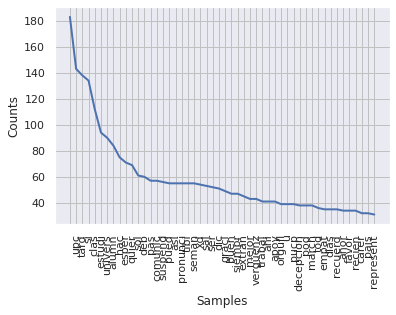

In [28]:
frecuencias = nltk.FreqDist(tokens)
frecuencias.plot(50)

###Distribución de las etiquetas

In [29]:
dataIG_03.Etiquetado.value_counts()/dataIG_03.shape[0]*100

Positivo    44.659300
Negativo    31.706568
Neutro      23.634131
Name: Etiquetado, dtype: float64

##Análisis de datos

In [30]:
def langid_safe(tweet):
    try:
        return langid.classify(tweet)[0]
    except Exception as e:
        pass

In [31]:
def langdetect_safe(tweet):
    try:
        return detect(tweet)
    except Exception as e:
        pass

In [32]:
def textblob_safe(tweet):
    try:
        return textblob.TextBlob(tweet).detect_language()
    except Exception as e:
        pass   

In [33]:
dataIG_03_new = dataIG_03.copy()

In [34]:
dataIG_03_new['lang_langid'] = dataIG_03_new.Texto.apply(langid_safe)
dataIG_03_new['lang_langdetect'] = dataIG_03_new.Texto.apply(langdetect_safe)
dataIG_03_new['lang_textblob'] = dataIG_03_new.Texto.apply(textblob_safe)

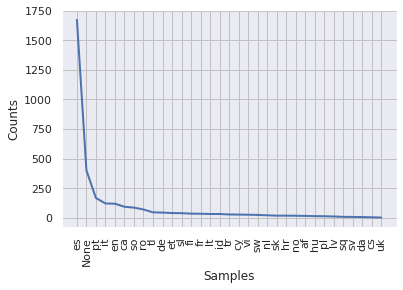

In [35]:
frecuencias = nltk.FreqDist(dataIG_03_new.lang_langdetect)
frecuencias.plot()

##Inicializando variables

In [36]:
##Creando el Corpus y Target
Corpus = list(dataIG_03.Texto2)
Target = list(dataIG_03.Etiquetado)
print(Corpus)
print(Target)

['much graci', 'felicit gran trabaj alexis orgulloupn', 'felic excelent trabaj', 'felicit fotograf sal herm', 'much graci ️', '', 'crack', '', '', 'wow', 'crack', 'tremend geni', 'eow cap', '', 'tmb herman vam', 'mejor herman', '', '', 'vist espectacul', '', 'genial cap', '', 'herm fot', 'geni', 'wow', 'sup', 'cap', '', '', 'crack', 'felic', '', 'fotaz', '', 'excelent fotograf felic', '', '', '', '', '', 'cuarenten injust pong fech pag cuand trabaj ingres conscient mund pas', 'gust elenc danz', 'selecion varon', 'cas', 'elenc danz', 'elenc danz genial', '', 'futbol', 'jajaj', 'andas', 'jajaj fans', '', 'jajajaj', 'publiqu jueg part verl', 'felicit', 'varon', 'exact hac particip', 'ide tbm quier particip algun info', 'convocatori inici cad cicl pued acercart oficin vid universitari campus pre inscripcion prueb tecnic esper', 'form equip', 'brav', '', 'inform gust form part equip', '', 'deberi ten jud', 'bien sobrin', 'salg gordit', 'wapaax', 'bie ahi', 'hag quier pertenec', '', 'jajajaj

##Vectorización del corpus: Bag-of-words

In [37]:
def vectorizar_bag_of_words(x_train, x_test):
  vec = CountVectorizer(
            analyzer = 'word',
            tokenizer = tokenize,
            lowercase = True,
            stop_words = spanish_stopwords
            )

  x_train_vectorizer = vec.fit_transform(x_train)
  x_test_vectorizar = vec.transform(x_test)

  return x_train_vectorizer, x_test_vectorizar

##Vectorización del corpus: TF-IDF

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize

In [39]:
import nltk 
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [40]:
def vectorizar_tf_idf(x_train, x_test):
  tfv = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=None)
  
  x_train_vectorizer = tfv.fit_transform(x_train)
  x_test_vectorizar = tfv.transform(x_test)

  return x_train_vectorizer, x_test_vectorizar

##Info

Corpus con Bag of words : **Corpus_bag_of_words**
 

Corpus con TF - IDF: **Corpus_TF_IDF**

Target: **Target**

Dataframe: **dataIG_03**

#Aplicando Algoritmos

##Función de Cross Validation

In [41]:
folds_number = 5

In [42]:
def get_model(modelType):
  n_estimators = 500
  use_bootstrap = True

  log_clf = LogisticRegression()
  svm_clf = SVC()
  knn = KNeighborsClassifier(n_neighbors=3)
  decisionTree = DecisionTreeClassifier()
  mlp = MLPClassifier(random_state=1, max_iter=100)
  bayes = MultinomialNB()

  voto_clf = VotingClassifier(estimators=[('lr', log_clf), ('svc', svm_clf), ('knn', knn), ('decisionTree', decisionTree), ('mlp', mlp), ('bayes', bayes) ], voting='hard')
  bag_knn = BaggingClassifier(knn, n_estimators=n_estimators, bootstrap=use_bootstrap)
  bag_log = BaggingClassifier(log_clf, n_estimators=n_estimators, bootstrap=use_bootstrap)
  bag_svm = BaggingClassifier(svm_clf, n_estimators=n_estimators, bootstrap=use_bootstrap)
  bag_tree = BaggingClassifier(decisionTree, n_estimators=n_estimators, bootstrap=use_bootstrap)
  bag_mlp = BaggingClassifier(mlp, n_estimators=n_estimators, bootstrap=use_bootstrap)
  bag_bayes = BaggingClassifier(bayes, n_estimators=n_estimators, bootstrap=use_bootstrap)

  switcher = {
        "knn": knn,
        "log": log_clf,
        "svm": svm_clf,
        "tree": decisionTree,
        "mlp": mlp,
        "bayes": bayes,
        "emsemble_v": voto_clf,
        "ensemble_b_knn": bag_knn,
        "ensemble_b_log": bag_log,
        "ensemble_b_svm": bag_svm,
        "ensemble_b_tree": bag_tree,
        "ensemble_b_mlp": bag_mlp,
        "ensemble_b_bayes": bag_bayes
    }

  return switcher.get(modelType)

In [43]:
def applied_model(x, y, modelType, use_bag_of_words = True):
  accuracy_average = 0

  kf = KFold(n_splits = folds_number)
  for fold, (entrenamiento, validacion) in enumerate(kf.split(X=x, y=y)):
    X_test = x.iloc[validacion, 2]
    y_test = x.iloc[validacion, 1]

    X_train = x.iloc[entrenamiento, 2]
    y_train = x.iloc[entrenamiento, 1]
    
    y_train_list = list(y_train)
    y_test_list = list(y_test)

    if (use_bag_of_words):
      x_train_vector, x_test_vector = vectorizar_bag_of_words(X_train, X_test)
    else:
      x_train_vector, x_test_vector = vectorizar_tf_idf(X_train, X_test)

    model = get_model(modelType)

    model.fit(x_train_vector, y_train_list)
    y_pred = model.predict(x_test_vector)

    acc = accuracy_score(y_test, y_pred)
    accuracy_average = accuracy_average + acc

  print("Accuracy promedio")
  print("=====================")
  print(accuracy_average / folds_number)

  return (y_test, y_pred)

In [44]:
def show_metric(y_test, y_pred):
  print("Métricas:")
  print("============")
  print(metrics.classification_report(y_test,y_pred))
  print("\nMatríz de confusión:")
  print("========================")
  print(pd.crosstab(y_test,y_pred,rownames = ['Real'],colnames = ['Predicho']))

##KNN con Bag of words

In [45]:
y_test, y_pred = applied_model(dataIG_03, Target, "knn", use_bag_of_words = True)

Accuracy promedio
0.5969598446938642


In [46]:
show_metric(y_test, y_pred)

Métricas:
              precision    recall  f1-score   support

    Negativo       0.65      0.23      0.34       145
      Neutro       0.72      0.06      0.11       228
    Positivo       0.45      0.94      0.61       278

    accuracy                           0.47       651
   macro avg       0.61      0.41      0.35       651
weighted avg       0.59      0.47      0.37       651


Matríz de confusión:
Predicho  Negativo  Neutro  Positivo
Real                                
Negativo        33       1       111
Neutro           5      13       210
Positivo        13       4       261


##KNN con TF-IDF

In [47]:
y_test, y_pred = applied_model(dataIG_03, Target, "knn", use_bag_of_words = False)

Accuracy promedio
0.5892802955340063


In [48]:
show_metric(y_test, y_pred)

Métricas:
              precision    recall  f1-score   support

    Negativo       0.66      0.14      0.24       145
      Neutro       0.76      0.07      0.13       228
    Positivo       0.45      0.96      0.61       278

    accuracy                           0.47       651
   macro avg       0.62      0.39      0.33       651
weighted avg       0.60      0.47      0.36       651


Matríz de confusión:
Predicho  Negativo  Neutro  Positivo
Real                                
Negativo        21       0       124
Neutro           6      16       206
Positivo         5       5       268


##Regresión Logística con Bag of words

In [49]:
y_test, y_pred = applied_model(dataIG_03, Target, "log", use_bag_of_words = True)

Accuracy promedio
0.6110735725123217


In [50]:
show_metric(y_test, y_pred)

Métricas:
              precision    recall  f1-score   support

    Negativo       0.59      0.36      0.45       145
      Neutro       0.36      0.09      0.15       228
    Positivo       0.46      0.84      0.60       278

    accuracy                           0.47       651
   macro avg       0.47      0.43      0.40       651
weighted avg       0.46      0.47      0.40       651


Matríz de confusión:
Predicho  Negativo  Neutro  Positivo
Real                                
Negativo        52      15        78
Neutro          13      21       194
Positivo        23      22       233


##Regresión Logística con TF-IDF

In [51]:
y_test, y_pred = applied_model(dataIG_03, Target, "log", use_bag_of_words = False)

Accuracy promedio
0.6255011167340476


In [52]:
show_metric(y_test, y_pred)

Métricas:
              precision    recall  f1-score   support

    Negativo       0.63      0.40      0.49       145
      Neutro       0.58      0.08      0.15       228
    Positivo       0.47      0.89      0.62       278

    accuracy                           0.50       651
   macro avg       0.56      0.46      0.42       651
weighted avg       0.54      0.50      0.42       651


Matríz de confusión:
Predicho  Negativo  Neutro  Positivo
Real                                
Negativo        58       6        81
Neutro          12      19       197
Positivo        22       8       248


##SVM con Bag of words

In [53]:
y_test, y_pred = applied_model(dataIG_03, Target, "svm", use_bag_of_words = True)

Accuracy promedio
0.6073911773298276


In [54]:
show_metric(y_test, y_pred)

Métricas:
              precision    recall  f1-score   support

    Negativo       0.51      0.41      0.46       145
      Neutro       0.62      0.06      0.10       228
    Positivo       0.45      0.83      0.58       278

    accuracy                           0.47       651
   macro avg       0.53      0.43      0.38       651
weighted avg       0.52      0.47      0.39       651


Matríz de confusión:
Predicho  Negativo  Neutro  Positivo
Real                                
Negativo        60       4        81
Neutro          15      13       200
Positivo        43       4       231


##SVM con TF-IDF

In [55]:
y_test, y_pred = applied_model(dataIG_03, Target, "svm", use_bag_of_words = False)

Accuracy promedio
0.6055775446929217


In [56]:
show_metric(y_test, y_pred)

Métricas:
              precision    recall  f1-score   support

    Negativo       0.66      0.50      0.57       145
      Neutro       0.73      0.07      0.13       228
    Positivo       0.48      0.90      0.63       278

    accuracy                           0.52       651
   macro avg       0.62      0.49      0.44       651
weighted avg       0.61      0.52      0.44       651


Matríz de confusión:
Predicho  Negativo  Neutro  Positivo
Real                                
Negativo        73       2        70
Neutro          13      16       199
Positivo        24       4       250


##Árboles con Bag of words

In [57]:
y_test, y_pred = applied_model(dataIG_03, Target, "tree", use_bag_of_words = True)

Accuracy promedio
0.5622817185453244


In [58]:
show_metric(y_test, y_pred)

Métricas:
              precision    recall  f1-score   support

    Negativo       0.53      0.38      0.44       145
      Neutro       0.33      0.11      0.16       228
    Positivo       0.45      0.76      0.56       278

    accuracy                           0.45       651
   macro avg       0.44      0.42      0.39       651
weighted avg       0.42      0.45      0.40       651


Matríz de confusión:
Predicho  Negativo  Neutro  Positivo
Real                                
Negativo        55      15        75
Neutro          16      24       188
Positivo        32      34       212


##Árboles con TF-IDF

In [59]:
y_test, y_pred = applied_model(dataIG_03, Target, "tree", use_bag_of_words = False)

Accuracy promedio
0.562274179412513


In [60]:
show_metric(y_test, y_pred)

Métricas:
              precision    recall  f1-score   support

    Negativo       0.53      0.43      0.47       145
      Neutro       0.28      0.08      0.12       228
    Positivo       0.45      0.75      0.56       278

    accuracy                           0.44       651
   macro avg       0.42      0.42      0.39       651
weighted avg       0.41      0.44      0.39       651


Matríz de confusión:
Predicho  Negativo  Neutro  Positivo
Real                                
Negativo        62      12        71
Neutro          21      18       189
Positivo        34      35       209


##MLP con Bag of words

In [61]:
y_test, y_pred = applied_model(dataIG_03, Target, "mlp", use_bag_of_words = True)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy promedio
0.5911344510097727


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [62]:
show_metric(y_test, y_pred)

Métricas:
              precision    recall  f1-score   support

    Negativo       0.54      0.40      0.46       145
      Neutro       0.32      0.10      0.15       228
    Positivo       0.46      0.78      0.58       278

    accuracy                           0.46       651
   macro avg       0.44      0.43      0.40       651
weighted avg       0.43      0.46      0.40       651


Matríz de confusión:
Predicho  Negativo  Neutro  Positivo
Real                                
Negativo        58      25        62
Neutro          13      23       192
Positivo        37      25       216


##MLP con TF-IDF

In [63]:
y_test, y_pred = applied_model(dataIG_03, Target, "mlp", use_bag_of_words = False)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy promedio
0.6074166219030656


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [64]:
show_metric(y_test, y_pred)

Métricas:
              precision    recall  f1-score   support

    Negativo       0.51      0.44      0.47       145
      Neutro       0.56      0.77      0.65       228
    Positivo       0.68      0.51      0.58       278

    accuracy                           0.59       651
   macro avg       0.58      0.57      0.57       651
weighted avg       0.60      0.59      0.58       651


Matríz de confusión:
Predicho  Negativo  Neutro  Positivo
Real                                
Negativo        64      45        36
Neutro          21     176        31
Positivo        41      95       142


##Bayes con Bag of words

In [65]:
y_test, y_pred = applied_model(dataIG_03, Target, "bayes", use_bag_of_words = True)

Accuracy promedio
0.6239593640741473


In [66]:
show_metric(y_test, y_pred)

Métricas:
              precision    recall  f1-score   support

    Negativo       0.57      0.52      0.54       145
      Neutro       0.44      0.09      0.15       228
    Positivo       0.48      0.82      0.61       278

    accuracy                           0.50       651
   macro avg       0.50      0.48      0.43       651
weighted avg       0.49      0.50      0.43       651


Matríz de confusión:
Predicho  Negativo  Neutro  Positivo
Real                                
Negativo        76      13        56
Neutro          21      21       186
Positivo        37      14       227


##Bayes con TF-IDF

In [67]:
y_test, y_pred = applied_model(dataIG_03, Target, "bayes", use_bag_of_words = False)

Accuracy promedio
0.6215176274349044


In [68]:
show_metric(y_test, y_pred)

Métricas:
              precision    recall  f1-score   support

    Negativo       0.61      0.54      0.57       145
      Neutro       0.72      0.06      0.11       228
    Positivo       0.49      0.88      0.63       278

    accuracy                           0.52       651
   macro avg       0.61      0.49      0.43       651
weighted avg       0.60      0.52      0.43       651


Matríz de confusión:
Predicho  Negativo  Neutro  Positivo
Real                                
Negativo        78       3        64
Neutro          19      13       196
Positivo        31       2       245


##Ensembles

In [69]:
log_clf = LogisticRegression()
svm_clf = SVC()
knn = KNeighborsClassifier(n_neighbors=3)
decisionTree = DecisionTreeClassifier()
mlp = MLPClassifier(random_state=1, max_iter=100)
bayes = MultinomialNB()

### Ensemble por Voto

In [70]:
voto_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('svc', svm_clf), ('knn', knn), ('decisionTree', decisionTree), ('mlp', mlp), ('bayes', bayes) ], 
  voting='hard')

In [71]:
kf = KFold(n_splits = folds_number)
accuracy_average = 0
for fold, (entrenamiento, validacion) in enumerate(kf.split(X=dataIG_03, y=Target)):
  X_test = dataIG_03.iloc[validacion, 2]
  y_test = dataIG_03.iloc[validacion, 1]

  X_train = dataIG_03.iloc[entrenamiento, 2]
  y_train = dataIG_03.iloc[entrenamiento, 1]
  
  y_train_list = list(y_train)
  y_test_list = list(y_test)

  x_train_vector, x_test_vector = vectorizar_bag_of_words(X_train, X_test)

  voto_clf.fit(x_train_vector, y_train_list)
  
  y_pred = voto_clf.predict(x_test_vector)

  acc = accuracy_score(y_test, y_pred)

  print(f"Fold Number: {fold}")
  print("====================")
  for clf in (log_clf, svm_clf, knn, decisionTree, mlp, bayes, voto_clf):
    clf.fit(x_train_vector, y_train_list)
    y_pred = clf.predict(x_test_vector)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

  print("\n")
  accuracy_average = accuracy_average + acc

print("Acurracy Promedio: ")
print("====================")
print(f"{accuracy_average / folds_number}")

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fold Number: 0
LogisticRegression 0.6717791411042945
SVC 0.696319018404908
KNeighborsClassifier 0.6656441717791411
DecisionTreeClassifier 0.5950920245398773


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier 0.6748466257668712
MultinomialNB 0.74079754601227


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


VotingClassifier 0.7315950920245399




/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fold Number: 1
LogisticRegression 0.647239263803681
SVC 0.6457055214723927
KNeighborsClassifier 0.5766871165644172
DecisionTreeClassifier 0.6180981595092024


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier 0.6365030674846626
MultinomialNB 0.6533742331288344


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


VotingClassifier 0.656441717791411




/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fold Number: 2
LogisticRegression 0.6365030674846626
SVC 0.5996932515337423
KNeighborsClassifier 0.6533742331288344
DecisionTreeClassifier 0.5644171779141104


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier 0.5460122699386503
MultinomialNB 0.6180981595092024


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


VotingClassifier 0.5874233128834356




/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fold Number: 3
LogisticRegression 0.6298003072196621
SVC 0.6282642089093702
KNeighborsClassifier 0.6175115207373272
DecisionTreeClassifier 0.5852534562211982


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier 0.642089093701997
MultinomialNB 0.6098310291858678


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


VotingClassifier 0.6282642089093702




/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fold Number: 4
LogisticRegression 0.4700460829493088
SVC 0.46697388632872505
KNeighborsClassifier 0.4715821812596006
DecisionTreeClassifier 0.4470046082949309


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier 0.45622119815668205
MultinomialNB 0.4976958525345622
VotingClassifier 0.4731182795698925


Acurracy Promedio: 
0.6153689934315305


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### Ensemble por Bagging

####Aplicando en KNN con TF - IDF

In [72]:
y_test, y_pred = applied_model(dataIG_03, Target, "ensemble_b_knn", use_bag_of_words = False)

Accuracy promedio
0.4729957686617097


In [73]:
show_metric(y_test, y_pred)

Métricas:
              precision    recall  f1-score   support

    Negativo       0.69      0.19      0.29       145
      Neutro       0.66      0.08      0.15       228
    Positivo       0.45      0.94      0.60       278

    accuracy                           0.47       651
   macro avg       0.60      0.40      0.35       651
weighted avg       0.57      0.47      0.38       651


Matríz de confusión:
Predicho  Negativo  Neutro  Positivo
Real                                
Negativo        27       1       117
Neutro           3      19       206
Positivo         9       9       260


####Aplicando en KNN con Bag of words

In [74]:
y_test, y_pred = applied_model(dataIG_03, Target, "ensemble_b_knn", use_bag_of_words = True)

Accuracy promedio
0.5104355733981698


In [75]:
show_metric(y_test, y_pred)

Métricas:
              precision    recall  f1-score   support

    Negativo       0.71      0.26      0.38       145
      Neutro       0.44      0.08      0.14       228
    Positivo       0.45      0.91      0.60       278

    accuracy                           0.47       651
   macro avg       0.54      0.41      0.37       651
weighted avg       0.51      0.47      0.39       651


Matríz de confusión:
Predicho  Negativo  Neutro  Positivo
Real                                
Negativo        37       6       102
Neutro           7      19       202
Positivo         8      18       252


####Aplicando en R. Logistica con TF - IDF

In [76]:
y_test, y_pred = applied_model(dataIG_03, Target, "ensemble_b_log", use_bag_of_words = False)

Accuracy promedio
0.6181363263690594


In [77]:
show_metric(y_test, y_pred)

Métricas:
              precision    recall  f1-score   support

    Negativo       0.63      0.38      0.47       145
      Neutro       0.59      0.07      0.13       228
    Positivo       0.47      0.90      0.62       278

    accuracy                           0.50       651
   macro avg       0.56      0.45      0.41       651
weighted avg       0.55      0.50      0.42       651


Matríz de confusión:
Predicho  Negativo  Neutro  Positivo
Real                                
Negativo        55       6        84
Neutro          11      17       200
Positivo        21       6       251


####Aplicando en R. Logistica con Bag of words

In [78]:
y_test, y_pred = applied_model(dataIG_03, Target, "ensemble_b_log", use_bag_of_words = True)

Accuracy promedio
0.6126082572352115


In [79]:
show_metric(y_test, y_pred)

Métricas:
              precision    recall  f1-score   support

    Negativo       0.58      0.32      0.42       145
      Neutro       0.43      0.09      0.15       228
    Positivo       0.46      0.87      0.61       278

    accuracy                           0.48       651
   macro avg       0.49      0.43      0.39       651
weighted avg       0.48      0.48      0.40       651


Matríz de confusión:
Predicho  Negativo  Neutro  Positivo
Real                                
Negativo        47      14        84
Neutro          11      20       197
Positivo        23      12       243


####Aplicando en SVM con Bag of words

In [80]:
y_test, y_pred = applied_model(dataIG_03, Target, "ensemble_b_svm", use_bag_of_words = True)

Accuracy promedio
0.5902137344151989


In [81]:
show_metric(y_test, y_pred)

Métricas:
              precision    recall  f1-score   support

    Negativo       0.51      0.41      0.46       145
      Neutro       0.59      0.06      0.10       228
    Positivo       0.45      0.83      0.58       278

    accuracy                           0.47       651
   macro avg       0.52      0.43      0.38       651
weighted avg       0.51      0.47      0.39       651


Matríz de confusión:
Predicho  Negativo  Neutro  Positivo
Real                                
Negativo        60       4        81
Neutro          15      13       200
Positivo        43       5       230


####Aplicando en SVM con TF - IDF

In [82]:
y_test, y_pred = applied_model(dataIG_03, Target, "ensemble_b_svm", use_bag_of_words = False)

Accuracy promedio
0.6037342267205715


In [83]:
show_metric(y_test, y_pred)

Métricas:
              precision    recall  f1-score   support

    Negativo       0.66      0.48      0.56       145
      Neutro       0.85      0.07      0.14       228
    Positivo       0.48      0.91      0.63       278

    accuracy                           0.52       651
   macro avg       0.66      0.49      0.44       651
weighted avg       0.65      0.52      0.44       651


Matríz de confusión:
Predicho  Negativo  Neutro  Positivo
Real                                
Negativo        70       1        74
Neutro          13      17       198
Positivo        23       2       253


####Aplicando en Árboles con Bag of words

In [84]:
y_test, y_pred = applied_model(dataIG_03, Target, "ensemble_b_tree", use_bag_of_words = True)

Accuracy promedio
0.5791646640845137


In [85]:
show_metric(y_test, y_pred)

Métricas:
              precision    recall  f1-score   support

    Negativo       0.52      0.39      0.44       145
      Neutro       0.40      0.10      0.16       228
    Positivo       0.46      0.80      0.58       278

    accuracy                           0.46       651
   macro avg       0.46      0.43      0.40       651
weighted avg       0.45      0.46      0.40       651


Matríz de confusión:
Predicho  Negativo  Neutro  Positivo
Real                                
Negativo        56      14        75
Neutro          17      23       188
Positivo        35      21       222


####Aplicando en Árboles con TF - IDF

In [86]:
y_test, y_pred = applied_model(dataIG_03, Target, "ensemble_b_tree", use_bag_of_words = False)

Accuracy promedio
0.5920542252127449


In [87]:
show_metric(y_test, y_pred)

Métricas:
              precision    recall  f1-score   support

    Negativo       0.52      0.42      0.46       145
      Neutro       0.52      0.11      0.19       228
    Positivo       0.47      0.82      0.60       278

    accuracy                           0.48       651
   macro avg       0.50      0.45      0.42       651
weighted avg       0.50      0.48      0.42       651


Matríz de confusión:
Predicho  Negativo  Neutro  Positivo
Real                                
Negativo        61      11        73
Neutro          20      26       182
Positivo        37      13       228


####Aplicando en MLP con Bag of words

In [ ]:
y_test, y_pred = applied_model(dataIG_03, Target, "ensemble_b_mlp", use_bag_of_words = True)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
show_metric(y_test, y_pred)

####Aplicando en MLP con TF - IDF

In [ ]:
y_test, y_pred = applied_model(dataIG_03, Target, "ensemble_b_mlp", use_bag_of_words = True)

In [ ]:
show_metric(y_test, y_pred)

####Aplicando en Bayes con Bag of words

In [ ]:
y_test, y_pred = applied_model(dataIG_03, Target, "ensemble_b_bayes", use_bag_of_words = True)

In [ ]:
show_metric(y_test, y_pred)

####Aplicando en Bayes con TF - IDF

In [ ]:
y_test, y_pred = applied_model(dataIG_03, Target, "ensemble_b_bayes", use_bag_of_words = False)

In [ ]:
show_metric(y_test, y_pred)